In [1]:
from LSTM import *
from data_getter import *
import matplotlib.pyplot as plt
from IPython import display
import pickle
import time

In [2]:
directory = 'D:/archive/tensors/'

In [3]:
plot_data = {}
epochs = 2
for number_of_networks in range(1,3):
    if number_of_networks == 1:
        tensor =  get_tensor(directory)
    else:
        tensor = problem_number_get_tensor(directory)
    model = LSTM(tensor,3,3)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.7)
    #training
    for epoch in range(epochs):
        model.split_users()
        mini_batches = model.training_users.shape[0]//20
        for mini_batch_number in tqdm(range(mini_batches)):
            mini_batch = model.get_mini_batch('train')
            for n in range(1,model.days):
                data = mini_batch[mini_batch[:,1]==n]
                if data.shape[0]>0:
                    ground = data[:,-1].to(dtype=torch.float)
                    output = model(data)
                    loss = model.loss(ground,output)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    model.h.detach_()
                    model.C.detach_()
    file = open('models/problem_number_network_'+str(number_of_networks)+'_'+str(int(time.time()))+'.pkl', 'wb+')
    pickle.dump(model,file)
    file.close()
    #test
    x = []
    y = []
    z = []
    g = []
    batch_number = 0
    for mini_batch_number in tqdm(range(model.test_users.shape[0]//20)):
        mini_batch = model.get_mini_batch('test')
        batch_number += 1
        losses = []
        prediction_count = 0
        ground_count = 0
        problem_count = 0
        for n in range(1,model.days):
            data = mini_batch[mini_batch[:,1]==n]
            if data.shape[0]>0:
                output = model(data)
                ground = data[:,-1].to(dtype=torch.float)
                loss = model.loss(ground,output)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                losses.append(loss.item())
                prediction_count += torch.sum(output.round()).item()
                ground_count += torch.sum(ground.round()).item()
                problem_count += ground.shape[0]
                model.h.detach_()
                model.C.detach_()
        x.append(batch_number)
        y.append(sum(losses)/len(losses))
        z.append(prediction_count/problem_count)
        g.append(ground_count/problem_count)
    plot_data[number_of_networks] = (x,y,z,g)
file = open('data/problem_number_network_'+str(int(time.time()))+'.pkl', 'wb+')
pickle.dump(plot_data,file)
file.close()

100%|████████████████████████████████████████████████████████████████████████████████| 311/311 [29:27<00:00,  5.68s/it]


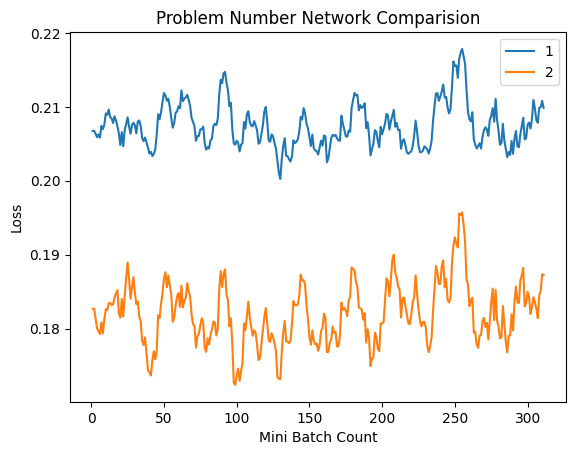

In [4]:
for key in plot_data.keys():
    x, y, _, _ = plot_data[key]
    y_padded = 10*[y[0]]+y
    running_sum = [sum(y_padded[n:n+10])/10 for n in range(len(y))]
    plt.plot(x,running_sum,label=str(key))
plt.title("Problem Number Network Comparision")
plt.xlabel("Mini Batch Count")
plt.ylabel("Loss")
plt.legend()
plt.show()

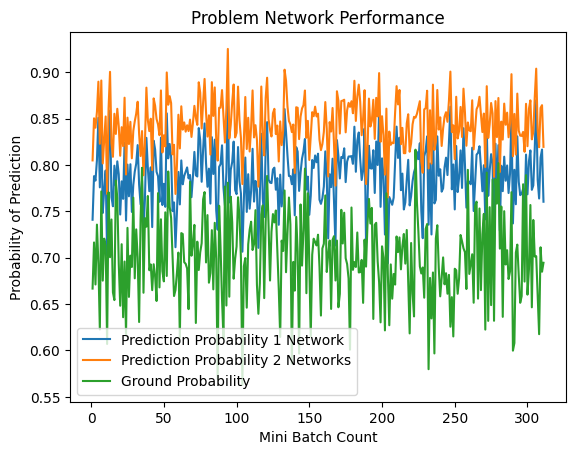

In [5]:
for key in plot_data.keys():
    x, _, z, g = plot_data[key]
    plt.plot(x,z,label='Prediction Probability '+str(key)+' Network'+'s'*(key-1))
plt.plot(x,g,label='Ground Probability')
plt.title("Problem Network Performance")
plt.xlabel("Mini Batch Count")
plt.ylabel("Probability of Prediction")
plt.legend()
plt.show()